In [1]:
%pylab inline

import pandas as pd
gold = 8.*np.array([1,1/((1+sqrt(5))/2)])

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This function makes the plots look prettier on GitHub. 
### to do: figure out how to make this automatic.

def fix_boxplot(parts):
    for m in parts['fliers']:
        m.set_markersize(12)
        m.set_markeredgewidth(1)
    for b in parts['boxes']:
        b.set_linewidth(2)
    for w in parts['whiskers']:
        w.set_linewidth(2)
    for c in parts['caps']:
        c.set_linewidth(2)
    for m in parts['medians']:
        m.set_linewidth(2)
    for m in parts['means']:
        m.set_linewidth(2)
        m.set_color('g')
        m.set_markerfacecolor('g')

# Problem 2.1

The text provides a Minitab file with a three column data set. I've extracted that data into a comma-delimited text file. (I have also changed the values to different distributions to prevent anyone from directly copying this work in a homework assignment.)

The data is 100 entries, formatted with three fields:
  * Income: household income in the sample
  * Ethnicity: three ethnic groups are seen in the population
  * Neighborhood: there are 20 neighboorhoods in the community, 5 from each in the sample

### Part A

First, we are asked to display the Income data by Ethnicity in a boxplot, calculate the means of each distribution, and discuss.

The boxplot can be done easily, either with matplotlib directly or, as done here, within a pandas dataframe. I have loaded the data with pandas, and created the boxplot. The <font color=#338833>by</font> keyword allows us to group the data by another column value.

The default matplotlib handling makes a very poor plot for display. spacepy.plot fixes a lot of those issues, but then generates plots that are poor for GitHub. I have, for now, used a brute-force function to get the plot to render nicely for this format.

For calculating the means, the pandas dataframe has a <font color=#338833; face=monospace>groupby</font> method to sort out each distribution. Each distribution can then calculate its own mean with its internal method. I have also displayed the value of the mean to two decimal places on each plot.

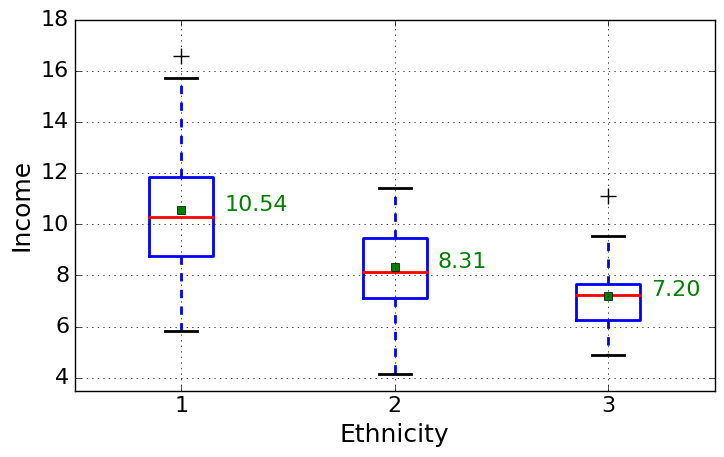

In [3]:
data = pd.read_csv('data_sample.txt')
parts = data.boxplot(column='Income',by='Ethnicity',showmeans=True,figsize=gold,fontsize=16,return_type='dict')
plt.title(''); plt.suptitle('')
plt.yticks(fontsize=16)
plt.ylabel("Income",fontsize=18)
plt.xlabel("Ethnicity",fontsize=18)
axis([0.5,3.5,3.5,18])
means = data.groupby(by='Ethnicity')['Income'].mean()
for eth in [1,2,3]:
    text(eth+0.2,means[eth],"{0:.2f}".format(means[eth]),color='g',fontsize=16)
fix_boxplot(parts['Income'])

We see three distinct distributions out of the ethnic groups, though 2 and 3 are quite similar.

### Part B

Next, we want to examine how a simple sampling method (one not taking any factors into account) affects the statistics of the sample distribution. Here, we create a new pandas data frame with 200 entries, each a random sample of 20 from the population. We keep track of the sample mean, and the count of sampled individuals from each ethnic group.

In [4]:
simple = pd.DataFrame(columns=["Mean","Count 1", "Count 2", "Count 3"])
for i in range(200):
    sample = data.sample(20,replace=False)
    counts=sample['Ethnicity'].value_counts()
    for k in [1,2,3]:
        if k not in counts.keys():
            counts[k]=0
    new_data = {'Mean':sample['Income'].mean(),
                'Count 1':counts[1],
                'Count 2':counts[2],
                'Count 3':counts[3]}
    simple = simple.append(new_data,ignore_index=True)

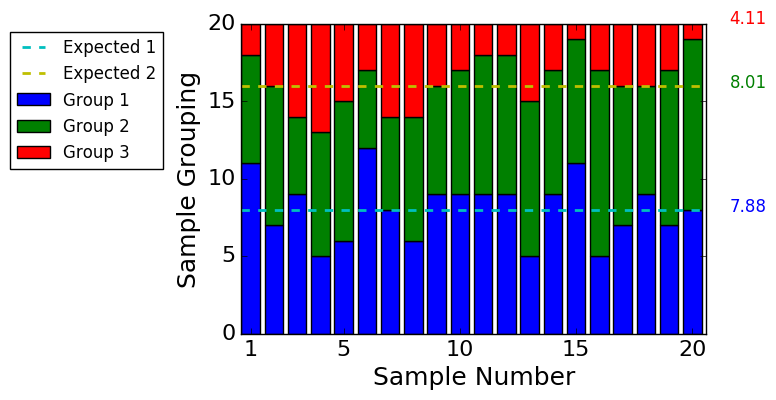

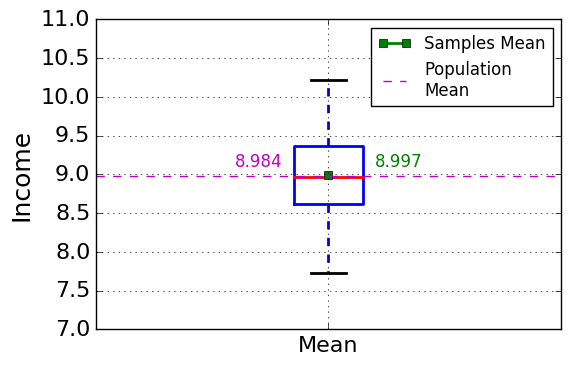

In [5]:
figure()
bar(range(20),simple['Count 1'][:20],color='b',label='Group 1')
bar(range(20),simple['Count 2'][:20],color='g',bottom=simple['Count 1'][:20],label='Group 2')
bar(range(20),simple['Count 3'][:20],color='r',bottom=simple['Count 1'][:20]+simple['Count 2'][:20],label='Group 3')
plot([0,20],[20*.4,20*.4],'c--',linewidth=2,label='Expected 1')
plot([0,20],[20*.8,20*.8],'y--',linewidth=2,label='Expected 2')
plt.xticks([0.4,4.4,9.4,14.4,19.4],[1,5,10,15,20],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Sample Number",fontsize=18)
plt.ylabel("Sample Grouping",fontsize=18)
legend(bbox_to_anchor=[-0.15,1.0])
text(21,simple['Count 1'].mean(),"{0:.2f}".format(simple['Count 1'].mean()),color='b',fontsize=12)
text(21,simple['Count 1'].mean()+simple['Count 2'].mean(),"{0:.2f}".format(simple['Count 2'].mean()),color='g',fontsize=12)
text(21,20,"{0:.2f}".format(simple['Count 3'].mean()),color='r',fontsize=12)

figure()
parts = simple.boxplot(column='Mean',showmeans=True,return_type='dict',fontsize=16)
parts['means'][0].set_label("Samples Mean")
plot([0.5,1.5],data['Income'].mean()*np.ones(2),'m--',label='Population\nMean')
plt.yticks(fontsize=16)
plt.ylabel("Income",fontsize=18)
fix_boxplot(parts)
axis([0.5,1.5,7.,11])
text(0.8,9.1,"{0:.3f}".format(data['Income'].mean()),color='m',fontsize=12)
text(1.1,9.1,"{0:.3f}".format(simple['Mean'].mean()),color='g',fontsize=12)
legend()

Clearly, a simple random sample does not always reproduce the strata in the population. It's even possible for one group to be entirely absent from the sample.

On average, however, the strata are present: a truly balanced sample of 20 would have 8 from Group 1, 8 from Group 2, and 4 from Group 3, and the average values for the 200 sample draws average to values close to those.

Additionally, the average of the mean sample income is quite close to the population mean income, and so we expect any variation there to be due to chance. For a specific random draw, it could be way off, but on average this method will reproduce the population parameters accurately.

### Part C

We next are asked to repeat the process, but using a stratified random sampling instead. In this case, we need random draws of 8 from each of Groups 1 and 2, and 4 from Group 3. We are asked the same questions, so I'll extract the same information as in Part B.

In [6]:
def group_sample(data,n,group,by):
    groups = data.groupby(by=by)
    idx = groups.indices[group]
    sample_idx = np.random.choice(idx,size=n,replace=False)
    sample = data[sample_idx[0]:sample_idx[0]+1]
    for i in range(1,n):
        sample = sample.append(data[sample_idx[i]:sample_idx[i]+1])
    return sample
        
stratified = pd.DataFrame(columns=["Mean","Count 1", "Count 2", "Count 3"])
for i in range(200):
    sample = group_sample(data,8,1,'Ethnicity')
    sample = sample.append(group_sample(data,8,2,'Ethnicity'))
    sample = sample.append(group_sample(data,4,3,'Ethnicity'))
    counts = sample.Ethnicity.value_counts()
    for k in [1,2,3]:
        if k not in counts.keys():
            counts[k] = 0
    new_data = {'Mean':sample.Income.mean(),
                'Count 1':counts[1],
                'Count 2':counts[2],
                'Count 3':counts[3]}
    stratified = stratified.append(new_data,ignore_index=True)


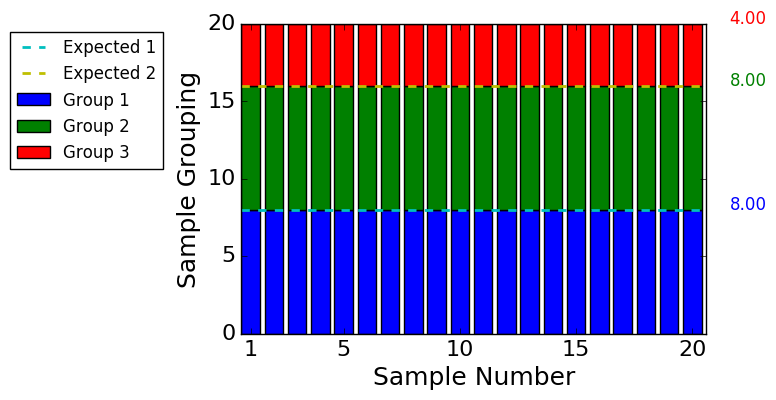

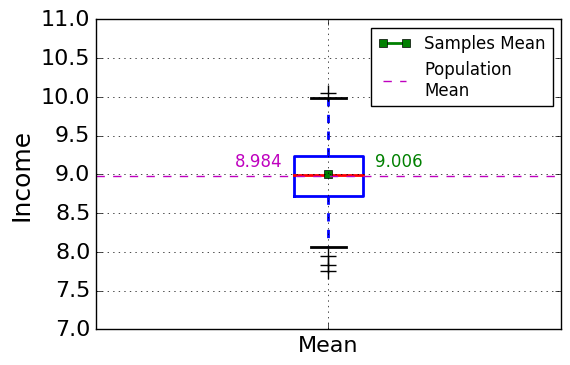

In [7]:
figure()
bar(range(20),stratified['Count 1'][:20],color='b',label='Group 1')
bar(range(20),stratified['Count 2'][:20],color='g',bottom=stratified['Count 1'][:20],label='Group 2')
bar(range(20),stratified['Count 3'][:20],color='r',bottom=stratified['Count 1'][:20]+stratified['Count 2'][:20],label='Group 3')
plot([0,20],[20*.4,20*.4],'c--',linewidth=2,label='Expected 1')
plot([0,20],[20*.8,20*.8],'y--',linewidth=2,label='Expected 2')
plt.xticks([0.4,4.4,9.4,14.4,19.4],[1,5,10,15,20],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Sample Number",fontsize=18)
plt.ylabel("Sample Grouping",fontsize=18)
legend(bbox_to_anchor=[-0.15,1.0])
text(21,stratified['Count 1'].mean(),"{0:.2f}".format(stratified['Count 1'].mean()),color='b',fontsize=12)
text(21,stratified['Count 1'].mean()+stratified['Count 2'].mean(),"{0:.2f}".format(stratified['Count 2'].mean()),color='g',fontsize=12)
text(21,20,"{0:.2f}".format(stratified['Count 3'].mean()),color='r',fontsize=12)

figure()
parts = stratified.boxplot(column='Mean',showmeans=True,return_type='dict',fontsize=16)
parts['means'][0].set_label("Samples Mean")
plot([0.5,1.5],data.Income.mean()*np.ones(2),'m--',label='Population\nMean')
plt.yticks(fontsize=16)
plt.ylabel("Income",fontsize=18)
fix_boxplot(parts)
axis([0.5,1.5,7.,11])
text(0.8,9.1,"{0:.3f}".format(data.Income.mean()),color='m',fontsize=12)
text(1.1,9.1,"{0:.3f}".format(stratified.Mean.mean()),color='g',fontsize=12)
legend()

In this case, the strata are reproduced exactly by design. The mean sample mean is likewise close to the expected value.

### Part D

Once more, but with clustered sampling. For this, we'll take a random sample by picking 4 neighboorhoods at random to get our sample of 20 individuals.

In [8]:
clustered = pd.DataFrame(columns=["Mean","Count 1", "Count 2", "Count 3"])
for i in range(200):
    neighbors = np.random.choice(list(set(data.Neighborhood.values)),size=4)
    sample = group_sample(data,5,neighbors[0],'Neighborhood')
    sample = sample.append(group_sample(data,5,neighbors[1],'Neighborhood'))
    sample = sample.append(group_sample(data,5,neighbors[2],'Neighborhood'))
    sample = sample.append(group_sample(data,5,neighbors[3],'Neighborhood'))
    counts = sample.Ethnicity.value_counts()
    for k in [1,2,3]:
        if k not in counts.keys():
            counts[k] = 0
    new_data = {'Mean':sample.Income.mean(),
                'Count 1':counts[1],
                'Count 2':counts[2],
                'Count 3':counts[3]}
    clustered = clustered.append(new_data,ignore_index=True)

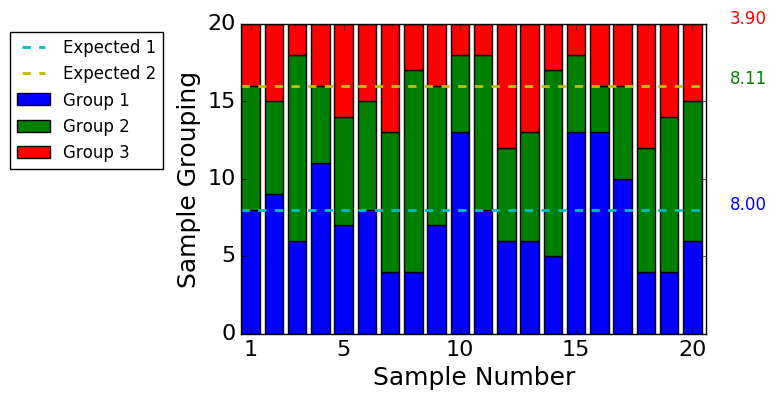

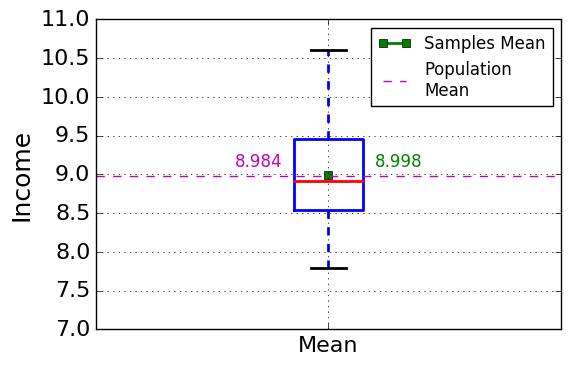

In [9]:
figure()
bar(range(20),clustered['Count 1'][:20],color='b',label='Group 1')
bar(range(20),clustered['Count 2'][:20],color='g',bottom=clustered['Count 1'][:20],label='Group 2')
bar(range(20),clustered['Count 3'][:20],color='r',bottom=clustered['Count 1'][:20]+clustered['Count 2'][:20],label='Group 3')
plot([0,20],[20*.4,20*.4],'c--',linewidth=2,label='Expected 1')
plot([0,20],[20*.8,20*.8],'y--',linewidth=2,label='Expected 2')
plt.xticks([0.4,4.4,9.4,14.4,19.4],[1,5,10,15,20],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Sample Number",fontsize=18)
plt.ylabel("Sample Grouping",fontsize=18)
legend(bbox_to_anchor=[-0.15,1.0])
text(21,clustered['Count 1'].mean(),"{0:.2f}".format(clustered['Count 1'].mean()),color='b',fontsize=12)
text(21,clustered['Count 1'].mean()+clustered['Count 2'].mean(),"{0:.2f}".format(clustered['Count 2'].mean()),color='g',fontsize=12)
text(21,20,"{0:.2f}".format(clustered['Count 3'].mean()),color='r',fontsize=12)

figure()
parts = clustered.boxplot(column='Mean',showmeans=True,return_type='dict',fontsize=16)
parts['means'][0].set_label("Samples Mean")
plot([0.5,1.5],data.Income.mean()*np.ones(2),'m--',label='Population\nMean')
plt.yticks(fontsize=16)
plt.ylabel("Income",fontsize=18)
fix_boxplot(parts)
axis([0.5,1.5,7.,11])
text(0.8,9.1,"{0:.3f}".format(data.Income.mean()),color='m',fontsize=12)
text(1.1,9.1,"{0:.3f}".format(clustered.Mean.mean()),color='g',fontsize=12)
legend()

In the clustered scheme, we are also unlikely to reproduce the strata, though on average we do. Again, the mean of the sample means is close to the population mean.

### Parts E & F

Now to compare the methods, we look at the distributions obtained for each together.

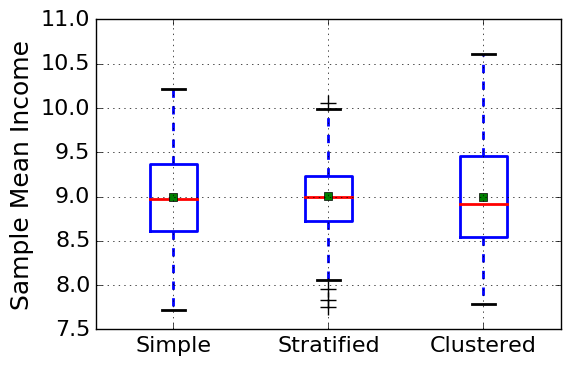

In [10]:
overall = pd.DataFrame(columns=["Simple", "Stratified", "Clustered"])
for i in range(200):
    overall = overall.append({"Simple":simple.Mean[i],
                              "Stratified":stratified.Mean[i],
                              "Clustered":clustered.Mean[i]}, ignore_index = True)
parts = overall.boxplot(showmeans=True,figsize=gold,fontsize=16,return_type='dict')
plt.title(''); plt.suptitle('')
plt.yticks(fontsize=16)
plt.ylabel("Sample Mean Income",fontsize=18)
fix_boxplot(parts)

While on average each mode can produce the right result, there's a lot more variation in the simple and clustered sampling methods in this case--obviously due to their inability to gaurantee a reproduction of the strata, and the income being tied very closely with ethnicity in this population. Since the stratified sampling method exactly reproduces that division, it is far more likely to produce a result close to the actual value than the other methods.